In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/641.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/173.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/815.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/491.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/718.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/709.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/379.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/780.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/248.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/94.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/480.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/236.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/771.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/675.png
/kaggle/input/image-s

Extracted 103455 patches of size 31x31 from the dataset.

Training DRRN model with 1 recursive blocks and gradient clipping...

Epoch 1/15


I0000 00:00:1727775572.852205      68 service.cc:145] XLA service 0x79b88c0352e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727775572.852266      68 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  5/728 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - accuracy: 0.3490 - loss: 1.6719

I0000 00:00:1727775576.478428      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


728/728 ━━━━━━━━━━━━━━━━━━━━ 37s 42ms/step - accuracy: 0.7857 - loss: 0.0578 - val_accuracy: 0.8941 - val_loss: 0.0011
Epoch 2/15
728/728 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - accuracy: 0.8703 - loss: 0.0011 - val_accuracy: 0.8942 - val_loss: 0.0011
Epoch 3/15
728/728 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - accuracy: 0.8759 - loss: 0.0010 - val_accuracy: 0.9120 - val_loss: 0.0011
Epoch 4/15
728/728 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - accuracy: 0.8760 - loss: 9.8931e-04 - val_accuracy: 0.8815 - val_loss: 0.0010
Epoch 5/15
728/728 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - accuracy: 0.8772 - loss: 9.6248e-04 - val_accuracy: 0.8745 - val_loss: 0.0010
Epoch 6/15
728/728 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - accuracy: 0.8787 - loss: 9.3940e-04 - val_accuracy: 0.8860 - val_loss: 9.9063e-04
Epoch 7/15
728/728 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - accuracy: 0.8798 - loss: 9.2524e-04 - val_accuracy: 0.8816 - val_loss: 9.7285e-04
Epoch 8/15
728/728 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - accuracy: 0.8779 - lo

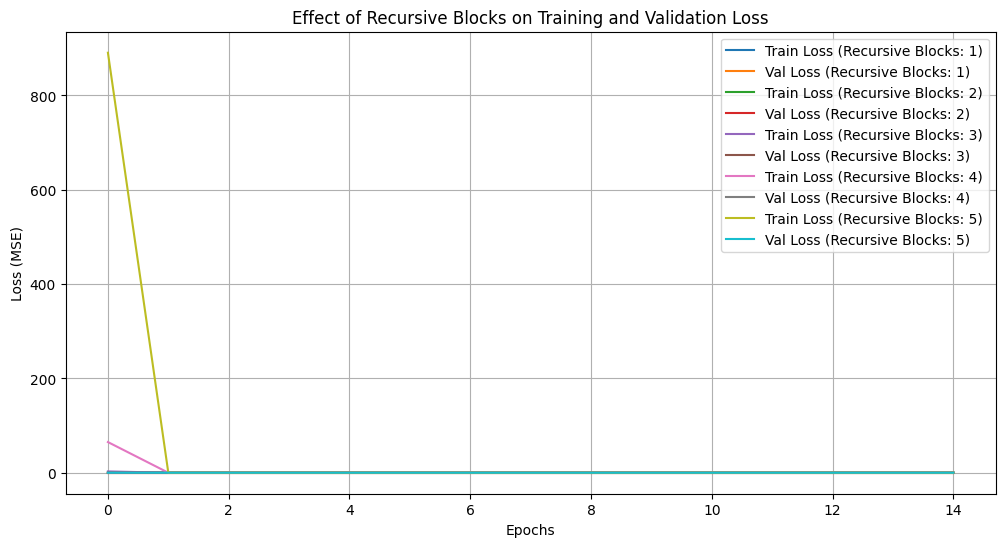

<Figure size 640x480 with 0 Axes>

In [2]:
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Residual Unit with two Conv layers and a residual connection
def residual_unit(input_tensor, filters, kernel_size=3):
    x = layers.Conv2D(filters, (kernel_size, kernel_size), padding='same')(input_tensor)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, (kernel_size, kernel_size), padding='same')(x)
    return layers.Add()([input_tensor, x])  # Local residual connection

# Recursive Block (with shared weights among residual units)
def recursive_block(input_tensor, num_residual_units, filters):
    x = input_tensor
    for _ in range(num_residual_units):
        x = residual_unit(x, filters)
    return x

# DRRN Model
def DRRN(input_shape, num_recursive_blocks, num_residual_units, filters):
    inputs = Input(shape=input_shape)

    # Initial Conv Layer
    x = layers.Conv2D(filters, (3, 3), padding='same')(inputs)

    # Recursive blocks with residual connections
    for _ in range(num_recursive_blocks):
        x = recursive_block(x, num_residual_units, filters)

    # Output Conv Layer to reconstruct residual image
    x = layers.Conv2D(3, (3, 3), padding='same')(x)

    # Global Residual Learning (add the input LR image to the predicted residual)
    outputs = layers.Add()([inputs, x])

    # Build model
    model = models.Model(inputs, outputs)
    return model

# Function to extract 31x31 patches with a stride of 21 from a single image
def extract_patches(image, patch_size=31, stride=21):
    patches = []
    h, w, _ = image.shape
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = image[y:y + patch_size, x:x + patch_size]
            patches.append(patch)
    return np.array(patches)

# Function to load images from a directory and extract low-res and high-res patches
def load_and_extract_patches(low_res_dir, high_res_dir, patch_size=31, stride=21):
    low_res_patches = []
    high_res_patches = []

    # Assuming filenames are identical for both low-res and high-res images
    for file_name in os.listdir(low_res_dir):
        # Load low-resolution image
        low_res_image_path = os.path.join(low_res_dir, file_name)
        low_res_image = cv2.imread(low_res_image_path)
        
        # Load high-resolution image
        high_res_image_path = os.path.join(high_res_dir, file_name)
        high_res_image = cv2.imread(high_res_image_path)
        
        # Ensure both images have at least patch_size dimensions and are the same size
        if (low_res_image.shape[0] >= patch_size and low_res_image.shape[1] >= patch_size and
            high_res_image.shape == low_res_image.shape):
            
            # Extract patches from both low-res and high-res images
            low_res_patches.extend(extract_patches(low_res_image, patch_size, stride))
            high_res_patches.extend(extract_patches(high_res_image, patch_size, stride))
    
    return np.array(low_res_patches), np.array(high_res_patches)

# Function to train and evaluate the model with gradient clipping and early stopping
def train_and_evaluate_drrn(num_recursive_blocks_list, num_residual_units, filters, input_shape, X_train, Y_train, epochs=5, patience=3):
    train_loss_histories = []
    val_loss_histories = []
    
    for num_recursive_blocks in num_recursive_blocks_list:
        print(f"\nTraining DRRN model with {num_recursive_blocks} recursive blocks and gradient clipping...\n")
        
        # Build the DRRN model
        drrn_model = DRRN(input_shape, num_recursive_blocks, num_residual_units, filters)
        
        # Set the optimizer with gradient clipping
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=1.0)  # Clip gradient values at 1.0
        
        # Compile the model with the clipped optimizer
        drrn_model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        
        # Train the model with early stopping
        history = drrn_model.fit(X_train, Y_train, batch_size=128, epochs=epochs, validation_split=0.1, verbose=1, callbacks=[early_stopping])
        
        # Save the loss history for plotting
        train_loss_histories.append(history.history['loss'])
        val_loss_histories.append(history.history['val_loss'])
        
        # Save the model for future use (optional)
        drrn_model.save(f"drrn_model_{num_recursive_blocks}_recursive_blocks_with_clipping.keras")
    
    return train_loss_histories, val_loss_histories

# Plotting function to visualize the effect of different numbers of recursive blocks
def plot_loss_histories(num_recursive_blocks_list, train_loss_histories, val_loss_histories):
    plt.figure(figsize=(12, 6))
    
    for i, num_recursive_blocks in enumerate(num_recursive_blocks_list):
        plt.plot(train_loss_histories[i], label=f'Train Loss (Recursive Blocks: {num_recursive_blocks})')
        plt.plot(val_loss_histories[i], label=f'Val Loss (Recursive Blocks: {num_recursive_blocks})')
    
    plt.title('Effect of Recursive Blocks on Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig("Result.png")

# Define the paths to your low-resolution and high-resolution images
low_res_dir = "/kaggle/input/image-super-resolution/dataset/Raw Data/low_res"
high_res_dir = "/kaggle/input/image-super-resolution/dataset/Raw Data/high_res"

# Extract low-res and high-res patches
X_train, Y_train = load_and_extract_patches(low_res_dir, high_res_dir, patch_size=31, stride=21)

# Normalize the patches (if necessary)
X_train = X_train / 255.0  # Normalize low-res patches (input)
Y_train = Y_train / 255.0  # Normalize high-res patches (target)

# Reshape the data for model input
X_train = X_train.reshape(-1, 31, 31, 3)  # Low-res patches
Y_train = Y_train.reshape(-1, 31, 31, 3)  # High-res patches

print(f"Extracted {X_train.shape[0]} patches of size 31x31 from the dataset.")

# Define the input shape (LR image), number of residual units in each block, and filters
input_shape = (31, 31, 3)  # (height, width, channels)
num_residual_units = 5      # Set a fixed number of residual units per block
filters = 64                # Number of filters in Conv layers

# Define the number of recursive blocks to test
num_recursive_blocks_list = [1,2,3,4,5]  

# Train and evaluate the model for different numbers of recursive blocks
train_loss_histories, val_loss_histories = train_and_evaluate_drrn(
    num_recursive_blocks_list, num_residual_units, filters, input_shape, X_train, Y_train, epochs=15, patience=3
)

# Plot the results
plot_loss_histories(num_recursive_blocks_list, train_loss_histories, val_loss_histories)


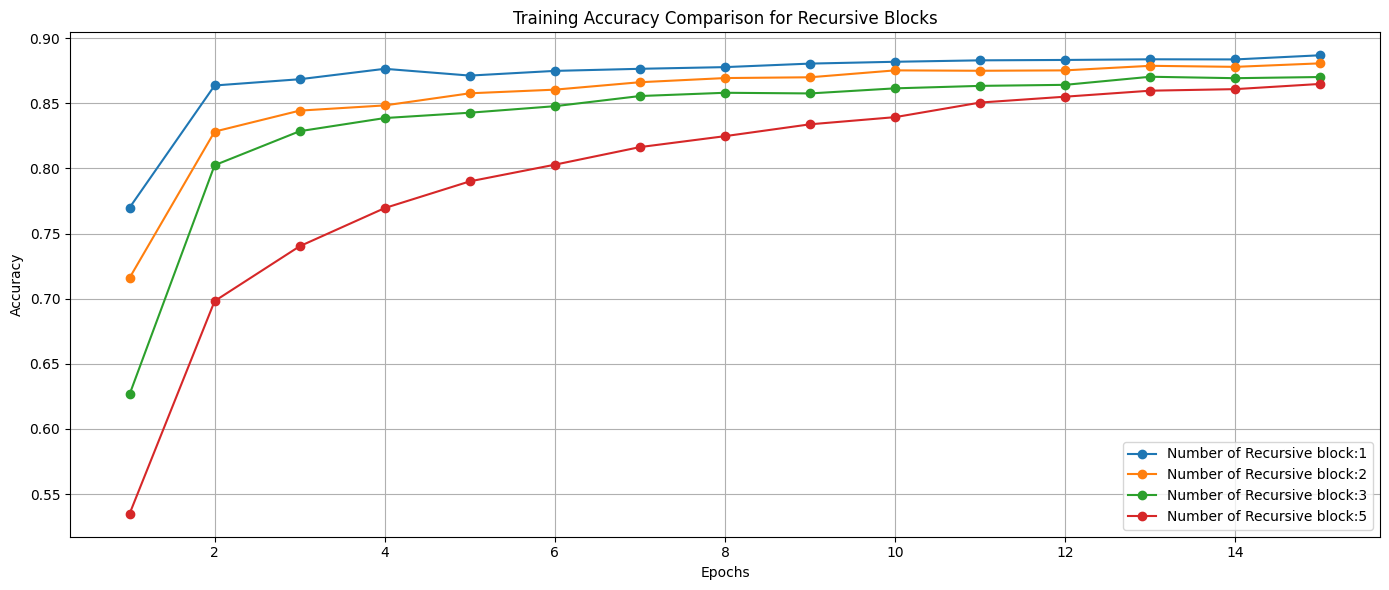

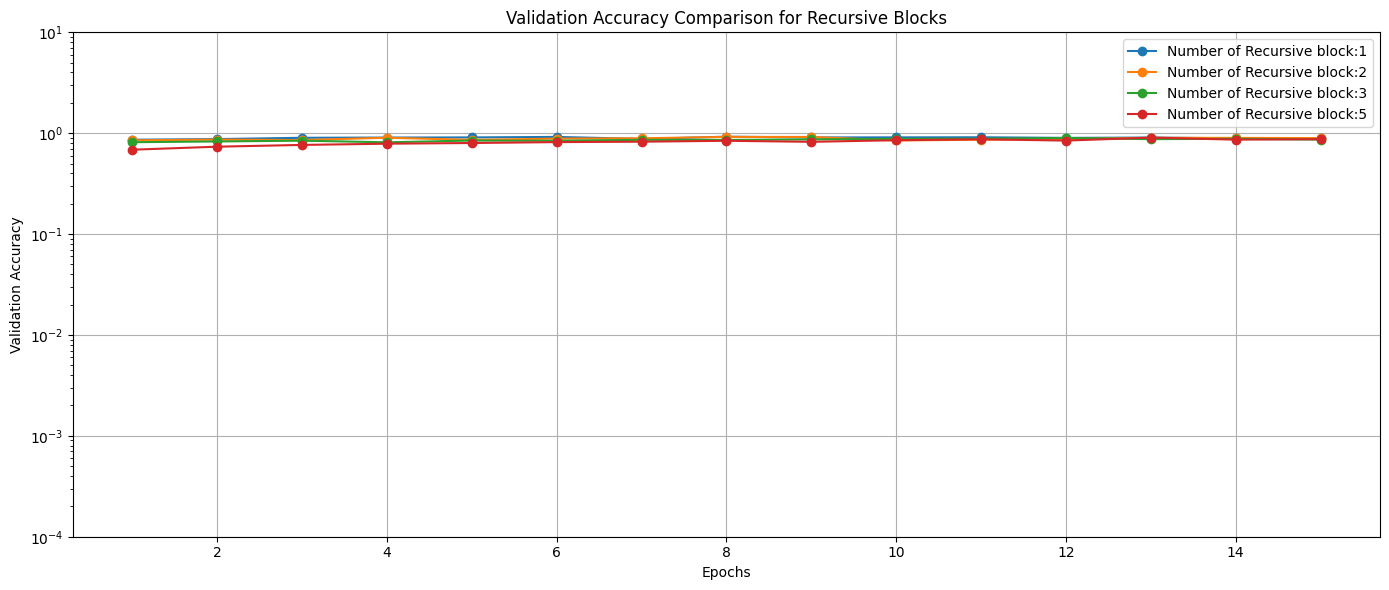

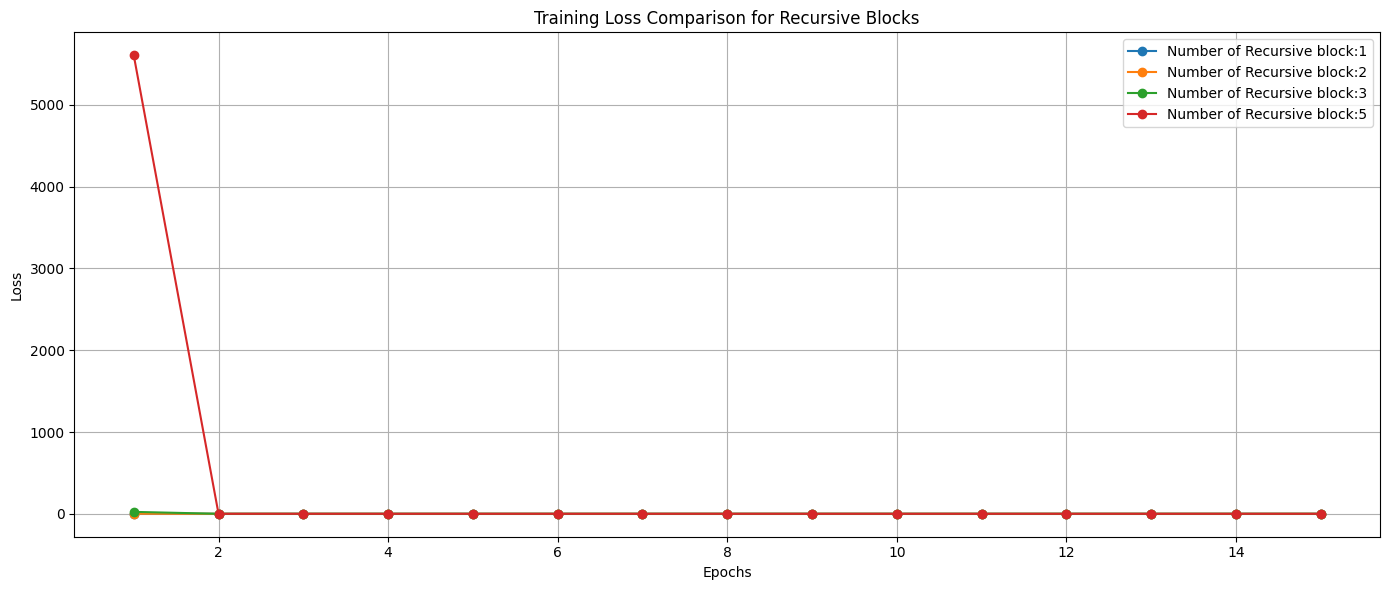

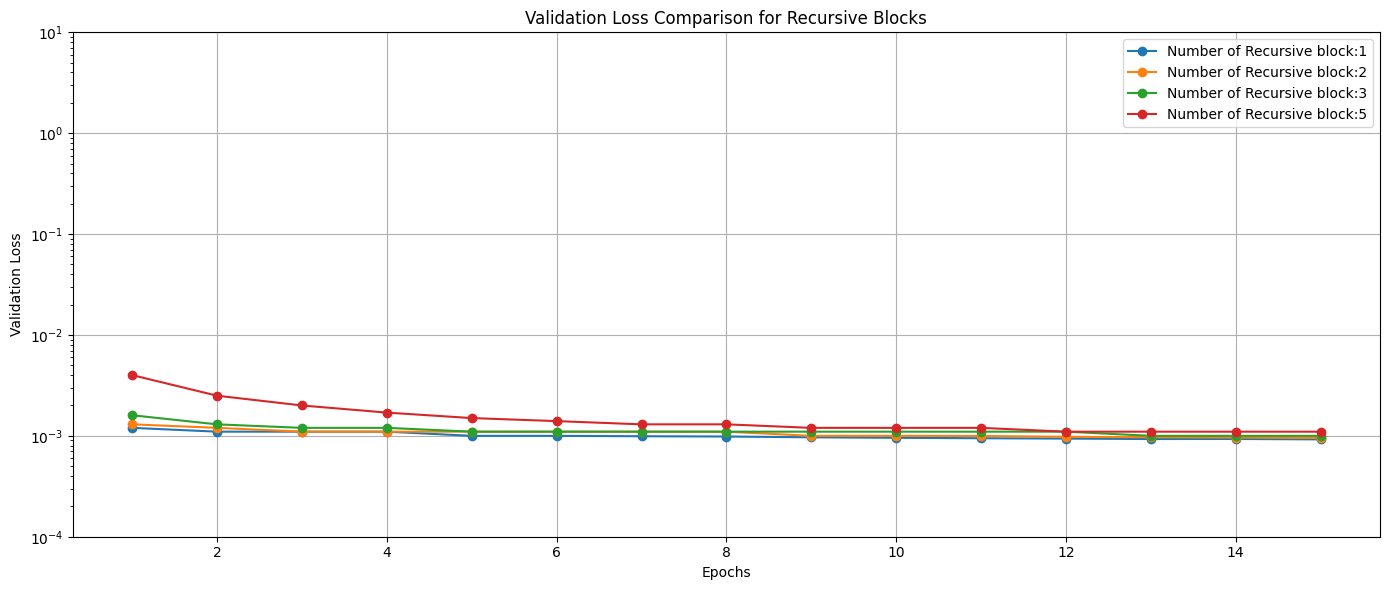

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Define the number of epochs
epochs = list(range(1, 16))

# Accuracy and loss data for each model (same as before)
accuracy_data = {
    1: [0.7699, 0.8637, 0.8685, 0.8765, 0.8713, 0.8749, 0.8765, 0.8778, 0.8805, 0.8819, 0.8830, 0.8833, 0.8838, 0.8837, 0.8869],
    2: [0.7160, 0.8283, 0.8444, 0.8484, 0.8577, 0.8605, 0.8662, 0.8694, 0.8700, 0.8753, 0.8750, 0.8753, 0.8788, 0.8780, 0.8807],
    3: [0.6266, 0.8025, 0.8286, 0.8387, 0.8428, 0.8478, 0.8556, 0.8581, 0.8576, 0.8615, 0.8634, 0.8642, 0.8704, 0.8693, 0.8702],
    5: [0.5349, 0.6982, 0.7403, 0.7696, 0.7901, 0.8029, 0.8164, 0.8248, 0.8339, 0.8394, 0.8506, 0.8551, 0.8597, 0.8609, 0.8649]
}

val_accuracy_data = {
    1: [0.8620, 0.8746, 0.9007, 0.9054, 0.9083, 0.9189, 0.8778, 0.9236, 0.9079, 0.9094, 0.9113, 0.8987, 0.9057, 0.8894, 0.8917],
    2: [0.8497, 0.8647, 0.8548, 0.9014, 0.8592, 0.8837, 0.8904, 0.9193, 0.9178, 0.8469, 0.8614, 0.8740, 0.9004, 0.8986, 0.8941],
    3: [0.8144, 0.8286, 0.8435, 0.8126, 0.8462, 0.8416, 0.8600, 0.8573, 0.8690, 0.8777, 0.8810, 0.8966, 0.8732, 0.8806, 0.8640],
    5: [0.6861, 0.7352, 0.7654, 0.7872, 0.7997, 0.8162, 0.8240, 0.8413, 0.8217, 0.8522, 0.8710, 0.8449, 0.9044, 0.8631, 0.8727]
}

loss_data = {
    1: [0.1391, 0.0011, 0.0011, 0.0010, 9.8739e-04, 9.7021e-04, 9.5610e-04, 9.2424e-04, 9.1321e-04, 9.1155e-04, 8.9935e-04, 8.9007e-04, 8.8597e-04, 8.6314e-04, 8.6118e-04],
    2: [0.6906, 0.0012, 0.0011, 0.0011, 0.0011, 0.0011, 0.0010, 9.9691e-04, 9.9209e-04, 9.6233e-04, 9.5246e-04, 9.3194e-04, 9.1840e-04, 9.0746e-04, 8.9134e-04],
    3: [23.4634, 0.0015, 0.0012, 0.0012, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0010, 0.0010, 0.0010, 0.0010, 9.8880e-04, 9.6753e-04],
    5: [5607.5479, 0.0038, 0.0025, 0.0019, 0.0016, 0.0015, 0.0014, 0.0013, 0.0013, 0.0012, 0.0012, 0.0011, 0.0011, 0.0011, 0.0011]
}

val_loss_data = {
    1: [0.0012, 0.0011, 0.0011, 0.0011, 0.0010, 0.0010, 9.9102e-04, 9.8483e-04, 9.6742e-04, 9.5605e-04, 9.4672e-04, 9.3901e-04, 9.2980e-04, 9.3118e-04, 9.2239e-04],
    2: [0.0013, 0.0012, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0010, 0.0010, 9.9715e-04, 9.7799e-04, 9.6849e-04, 9.6210e-04, 9.5034e-04],
    3: [0.0016, 0.0013, 0.0012, 0.0012, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0010, 0.0010, 0.0010],
    5: [0.0040, 0.0025, 0.0020, 0.0017, 0.0015, 0.0014, 0.0013, 0.0013, 0.0012, 0.0012, 0.0012, 0.0011, 0.0011, 0.0011, 0.0011]
}

# Function to plot comparison of all models
def plot_comparison(data_dict, metric_name, title, log_scale=False):
    plt.figure(figsize=(14, 6))
    for model_num, values in data_dict.items():
        plt.plot(epochs, values, label=f'Number of Recursive block:{model_num}', marker='o')
    
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    
    if log_scale:
        plt.yscale('log')
        plt.ylim([1e-4, 1e1])  # Adjust limits for log scale
    
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot accuracy comparison
plot_comparison(accuracy_data, 'Accuracy', 'Training Accuracy Comparison for Recursive Blocks')
# Plot validation accuracy in log scale
plot_comparison(val_accuracy_data, 'Validation Accuracy', 'Validation Accuracy Comparison for Recursive Blocks', log_scale=True)

# Plot loss comparison
plot_comparison(loss_data, 'Loss', 'Training Loss Comparison for Recursive Blocks')
# Plot validation loss in log scale
plot_comparison(val_loss_data, 'Validation Loss', 'Validation Loss Comparison for Recursive Blocks', log_scale=True)


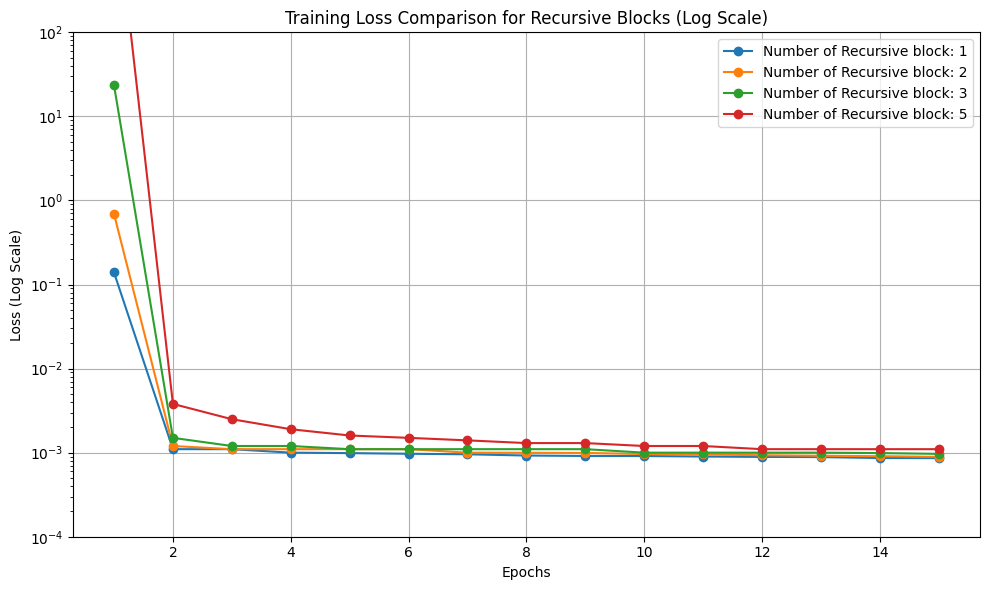

In [4]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = list(range(1, 16))

# Training loss data for each model
loss_data = {
    1: [0.1391, 0.0011, 0.0011, 0.0010, 9.8739e-04, 9.7021e-04, 9.5610e-04, 9.2424e-04, 9.1321e-04, 9.1155e-04, 8.9935e-04, 8.9007e-04, 8.8597e-04, 8.6314e-04, 8.6118e-04],
    2: [0.6906, 0.0012, 0.0011, 0.0011, 0.0011, 0.0011, 0.0010, 9.9691e-04, 9.9209e-04, 9.6233e-04, 9.5246e-04, 9.3194e-04, 9.1840e-04, 9.0746e-04, 8.9134e-04],
    3: [23.4634, 0.0015, 0.0012, 0.0012, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0010, 0.0010, 0.0010, 0.0010, 9.8880e-04, 9.6753e-04],
    5: [5607.5479, 0.0038, 0.0025, 0.0019, 0.0016, 0.0015, 0.0014, 0.0013, 0.0013, 0.0012, 0.0012, 0.0011, 0.0011, 0.0011, 0.0011]
}

# Function to plot training loss with log scale
def plot_training_loss(loss_dict):
    plt.figure(figsize=(10, 6))
    for model_num, values in loss_dict.items():
        plt.plot(epochs, values, label=f'Number of Recursive block: {model_num}', marker='o')
    
    plt.title('Training Loss Comparison for Recursive Blocks (Log Scale)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Log Scale)')
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.ylim([1e-4, 1e2])  # Adjust limits for log scale
    
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the function to plot the training loss
plot_training_loss(loss_data)
